In [0]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
# !pip install glove_python
# from glove import Corpus, Glove
from sklearn.model_selection import train_test_split

In [0]:
def loadData(path):
  data = pd.read_csv(path)
  data = data.dropna()
  print("Dimensions of dataset:", data.shape)
  print(data.columns)
  return data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def preProcessData(data):
  i = 0
  for i in range(data.shape[0]):
    #Tokenize on regex
    postTokens = tokenizer.tokenize(data['comment_text'][i])
    if i % 1000 == 0:
      print(i, postTokens)
      
    lemtzdTokens = []
    tokens = []
    
    #Remove stop words
    for token in postTokens:
      if token not in stopWords:
        tokens.append(token)
    tokenString = ' '.join(tokens)
    
    #Lowercase tokens
    tokenString = tokenString.lower()
    
    #Lemmatize tokens
    for token in nlp(tokenString):
      lemtzdTokens.append(token.lemma_)
    lemtzdTokens = ' '.join(lemtzdTokens)
    if i % 1000 == 0:
      print(lemtzdTokens)
      print()
    data['comment_text'][i] = lemtzdTokens
  return data

In [0]:
def dataAnalysis(data):
  print("Number of samples:", data.shape[0])

  i = 0
  commentLenStat = {}
  for i in range(data.shape[0]):
    comment = data.iloc[i]['comment_text']
    commentLen = len(comment.split())
    if commentLen in commentLenStat:
      commentLenStat[commentLen] += 1
    else:
      commentLenStat[commentLen] = 1

  lengths = []
  counts = []
  for key, val in sorted(commentLenStat.items()):
    lengths.append(key)
    counts.append(val)

  plt.bar(lengths, counts)
  plt.xlabel('Length of comment', fontsize=5)
  plt.ylabel('No of comments', fontsize=5)
  plt.title('Toxic Comment Classification')
  plt.show()

In [0]:
#Read train dataset
print("Train Data")
trainData = loadData("train.csv")

#Read test dataset
print("\nTest Features")
testDataFeatures = loadData("test.csv")
print("\nTest labels")
testDataLabels = loadData("test_labels.csv")

Train Data
Dimensions of dataset: (159571, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

Test Features
Dimensions of dataset: (153164, 2)
Index(['id', 'comment_text'], dtype='object')

Test labels
Dimensions of dataset: (153164, 7)
Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


In [0]:
tokenizer = RegexpTokenizer('[a-zA-Z]+')
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
nlp = spacy.load('en', disable=['parser', 'ner'])

#Clean train dataset
cleanTrainData = preProcessData(trainData)
cleanTrainData.to_csv('cleanTrain.csv')

#Clean test dataset
cleanTestData = preProcessData(testDataFeatures)
cleanTestData.to_csv('cleanTest.csv')

In [0]:
#Above cells for loading and preprocessing implemented one time.

In [0]:
#Load pre-processed train data
cleanTrainData = loadData("cleanTrain.csv")

#Load pre-processed test data
cleanTestData = loadData("cleanTest.csv")

#Load test labels
testDataLabels = loadData("test_labels.csv")

Dimensions of dataset: (159551, 9)
Index(['Unnamed: 0', 'id', 'comment_text', 'toxic', 'severe_toxic', 'obscene',
       'threat', 'insult', 'identity_hate'],
      dtype='object')
Dimensions of dataset: (152257, 3)
Index(['Unnamed: 0', 'id', 'comment_text'], dtype='object')
Dimensions of dataset: (153164, 7)
Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


In [0]:
#Drop unimportant columns
cleanTrainData = cleanTrainData.drop(['Unnamed: 0'], axis=1)
cleanTestData = cleanTestData.drop(['Unnamed: 0'], axis=1)

In [0]:
#Merge test features and labels
cleanTestData = pd.merge(cleanTestData, testDataLabels, how='inner')
print("Test dimensions after merging:", cleanTestData.shape)
print("Test columns after merging:", cleanTestData.columns)

Test dimensions after merging: (152257, 8)
Test columns after merging: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [0]:
#Drop unimportant rows (test rows with -1)
dropRows = []
for i in range(cleanTestData.shape[0]):
  for j in range(2, 8):
    if cleanTestData.iloc[i, j] == -1:
      dropRows.append(i)
      break
  
print("No. of Rows being dropped:", len(dropRows))
cleanTestData = cleanTestData.drop(cleanTestData.index[dropRows])

print("Test data dimensions after dropping ", cleanTestData.shape)
cleanTestData.to_csv('newCleanTest.csv')

No. of Rows being dropped: 0
Test data dimensions after dropping  (63566, 8)


In [0]:
#Selecting less data for fast processing
selectedCleanTrainData = cleanTrainData.sample(n = 8000)
selectedCleanTrainData.to_csv('cleanTrain8000.csv')

selectedCleanTestData = cleanTestData.sample(n = 2000)
selectedCleanTestData.to_csv('cleanTest2000.csv')

print(selectedCleanTrainData.shape)
print(selectedCleanTrainData.columns)
print(selectedCleanTestData.shape)
print(selectedCleanTestData.columns)
print(selectedCleanTestData.iloc[0])


(8000, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
(2000, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
id                                                aac8a884938daaff
comment_text     fowler fowler f f i still say politely ask was...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          1
threat                                                           0
insult                                                           1
identity_hate                                                    1
Name: 101698, dtype: object


Analysis on training data
Number of samples: 159551


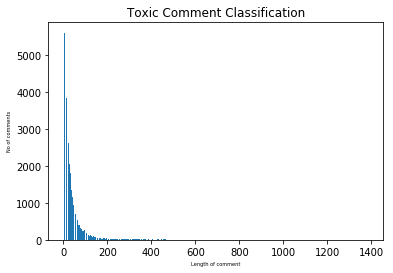

In [0]:
#Perform Data analysis
print("Analysis on training data")
dataAnalysis(cleanTrainData)